##  5.3 階層ベイズモデル

In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

import bambi as bmb
print(f"Running on ArViz v{bmb.__version__}")


Running on PyMC v5.16.2
Running on ArViz v0.19.0
Running on ArViz v0.14.0


### 5.3.1 問題設定
アイリスデータセットで３種類の花の回帰直線を同時に求める。  
データ数が少ないという条件の下で、３つの回帰直線は共通の傾向がある前提とする。  
この場合、階層ベイズモデルの問題に帰着する。


### 5.3.2 データ準備

####  アイリス・データセットの読み込みと内容の確認

In [3]:
# アイリスデータセットの読み込み
df = sns.load_dataset('iris')

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df['species'].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

#### 目標とするデータの抽出

In [4]:
# setosaの行のみ抽出
df0 = df.query('species == "setosa"')

# versicolorの行のみ抽出
df1 = df.query('species == "versicolor"')

# virginicaの行のみ抽出
df2 = df.query('species == "virginica"')

# 乱数により3個のインデックスを生成
import random
random.seed(42)
indexes =range(len(df0))
sample_indexes=random.sample(indexes, 3)

# df0, df1, df2のデータ数をそれぞれ3行にする
df0_sel = df0.iloc[sample_indexes]
df1_sel = df1.iloc[sample_indexes]
df2_sel = df2.iloc[sample_indexes]

#　全部連結して一つにする
df_sel = pd.concat([df0_sel, df1_sel, df2_sel]).reset_index(drop=True)

#### 加工結果の確認

In [5]:
display(df_sel)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.000,3.500,1.300,0.300,setosa
1,5.000,3.400,1.500,0.200,setosa
2,4.900,3.000,1.400,0.200,setosa
3,5.500,2.600,4.400,1.200,versicolor
4,4.900,2.400,3.300,1.000,versicolor
5,6.400,3.200,4.500,1.500,versicolor
6,6.700,3.100,5.600,2.400,virginica
7,7.300,2.900,6.300,1.800,virginica
8,5.800,2.700,5.100,1.900,virginica


#### 散布図による抽出結果表示

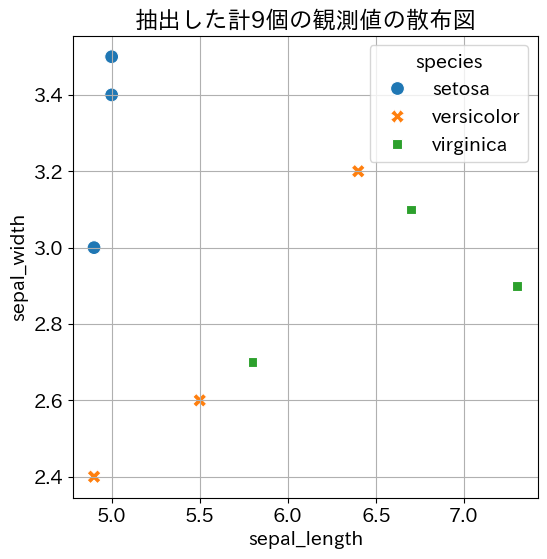

In [6]:
sns.scatterplot(
    x='sepal_length', y='sepal_width', hue='species', style='species',
    data=df_sel, s=100)
plt.title('抽出した計9個の観測値の散布図');

#### ベイス推論用変数の抽出

In [7]:
X = df_sel['sepal_length'].values
Y = df_sel['sepal_width'].values
species = df_sel['species']
cl = pd.Categorical(species).codes

# 結果確認
print(X)
print(Y)
print(species.values)
print(cl)

[5.000 5.000 4.900 5.500 4.900 6.400 6.700 7.300 5.800]
[3.500 3.400 3.000 2.600 2.400 3.200 3.100 2.900 2.700]
['setosa' 'setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor'
 'virginica' 'virginica' 'virginica']
[0 0 0 1 1 1 2 2 2]


### 5.3.3 確率モデル定義

#### 階層ベイズモデルの確率モデル定義

In [8]:
# 事前分布
priors = {
    # 階層ベイズ
    # 係数 α
    "sepal_length|species": bmb.Prior(
        "Normal",
        mu = bmb.Prior("Normal", mu = 0, sigma = 10),
        sigma = bmb.Prior("HalfNormal", sigma = 10)
    ),
    # 切片 β
    "1|species": bmb.Prior(
        "Normal",
        mu = bmb.Prior("Normal", mu = 0, sigma = 10),
        sigma = bmb.Prior("HalfNormal", sigma = 10)
    ),
    #"sepal_length": bmb.Prior("Normal", mu = 0, sigma = 10),
    #"Intercept": bmb.Prior("Normal", mu = 0, sigma = 10),# 書籍の β が対応する
    "sigma": bmb.Prior("HalfNormal", sigma = 1),# 書籍の ε が対応する
}

model1 = bmb.Model(
    formula = "sepal_width ~ 0 + (1 + sepal_length | species)",
    data = df_sel,
    priors = priors
)
model1

       Formula: sepal_width ~ 0 + (1 + sepal_length | species)
        Family: gaussian
          Link: mu = identity
  Observations: 9
        Priors: 
    target = mu
        Group-level effects
            1|species ~ Normal(mu: Normal(mu: 0.0, sigma: 10.0), sigma: HalfNormal(sigma: 10.0))
            sepal_length|species ~ Normal(mu: Normal(mu: 0.0, sigma: 10.0), sigma: HalfNormal(sigma: 10.0))
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)

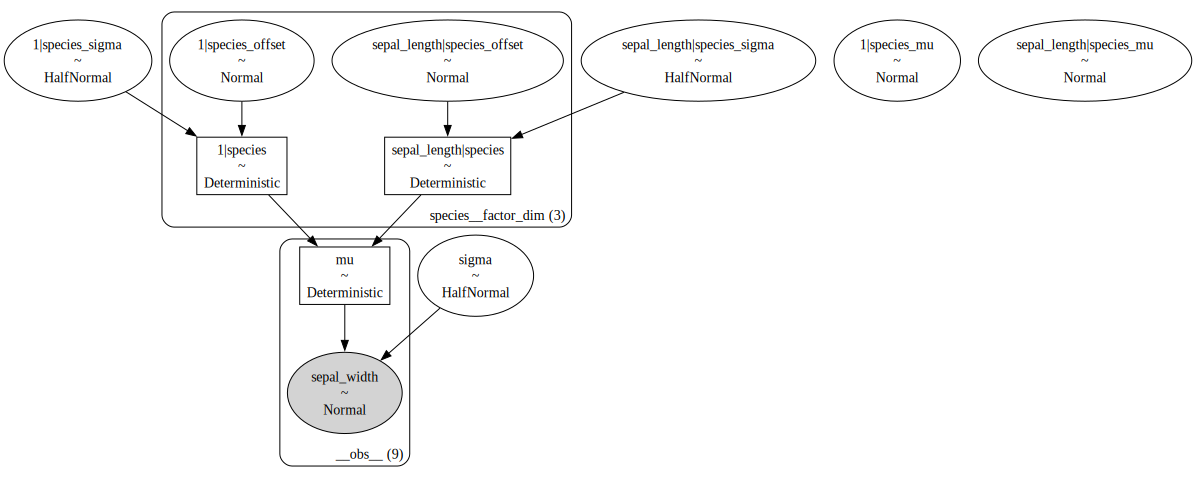

In [9]:
model1.build()
model1.graph()

### 5.3.4 サンプリングと結果分析

#### サンプリング

In [10]:
idata1 = model1.fit(random_seed = 42, nuts_sampler = "nutpie")

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:303: UserWarning: `var_names` are currently ignored by the nutpie sampler
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,33,0.13,95
,2000,31,0.15,127
,2000,22,0.12,127
,2000,52,0.14,111


#### plot_trace関数で推論結果の確認

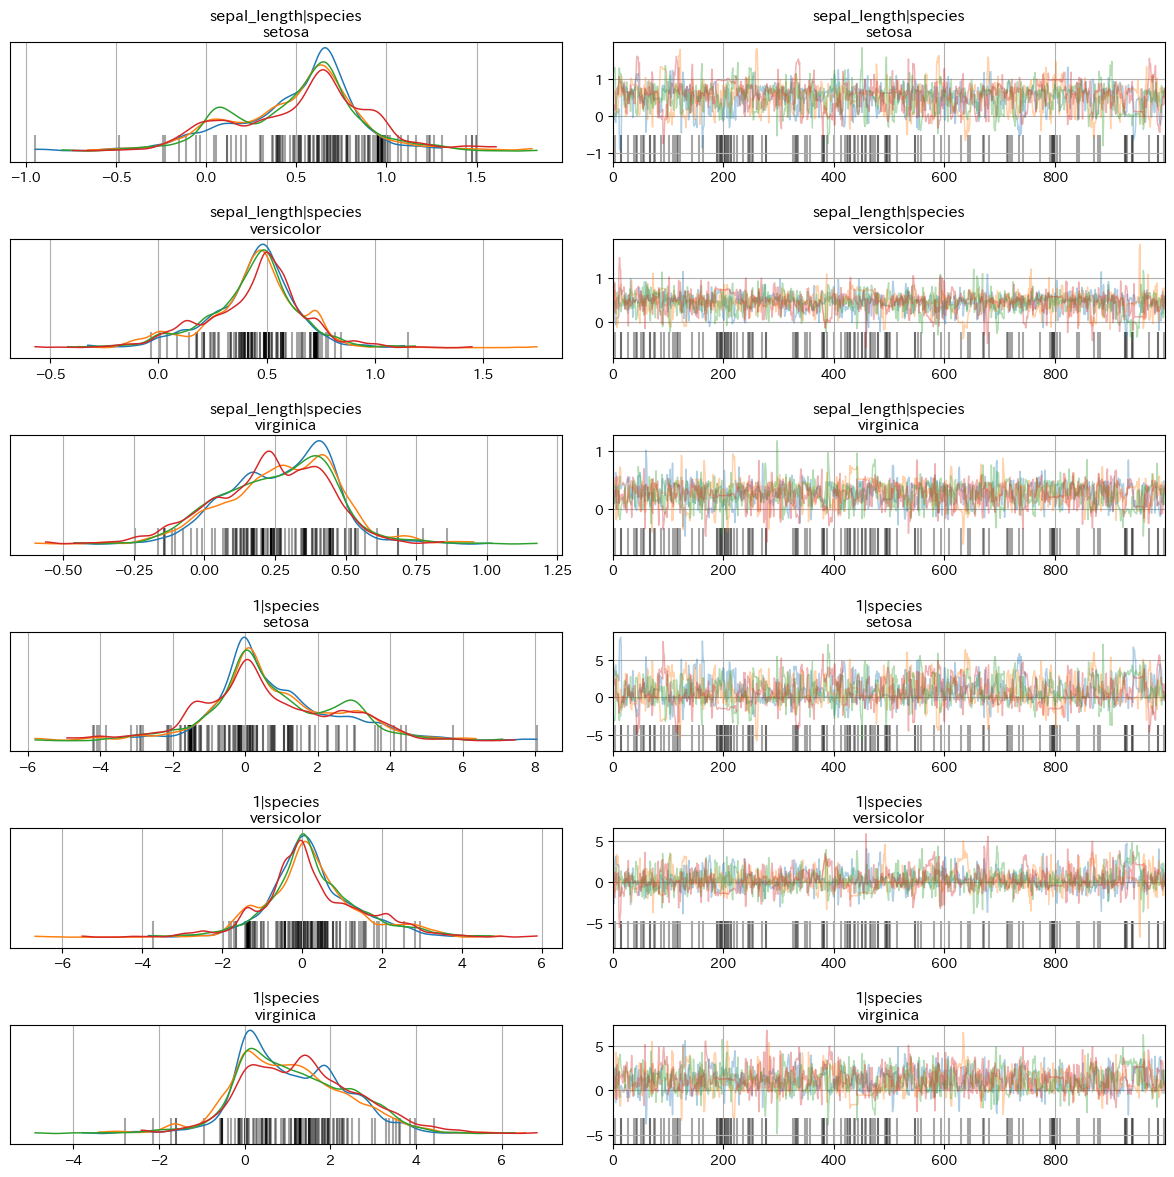

In [11]:
az.plot_trace(idata1, compact=False, var_names=['sepal_length|species', '1|species'])
plt.tight_layout();

#### summary関数で推論結果の確認

In [12]:
summary1 = az.summary(idata1, var_names=['sepal_length|species', '1|species'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sepal_length|species[setosa],0.507,0.357,-0.224,1.099,0.013,0.009,735.000,1092.000,1.010
sepal_length|species[versicolor],0.441,0.215,-0.011,0.795,0.008,0.006,669.000,677.000,1.000
sepal_length|species[virginica],0.263,0.198,-0.129,0.578,0.007,0.005,827.000,1478.000,1.010
1|species[setosa],0.779,1.770,-2.172,4.378,0.066,0.047,728.000,1040.000,1.010
1|species[versicolor],0.263,1.201,-1.739,2.846,0.047,0.033,661.000,728.000,1.000
1|species[virginica],1.152,1.310,-0.981,3.669,0.045,0.032,818.000,1564.000,1.010


### 5.3.5 散布図と回帰直線の重ね描き

#### 散布図と回帰直線の重ね描き

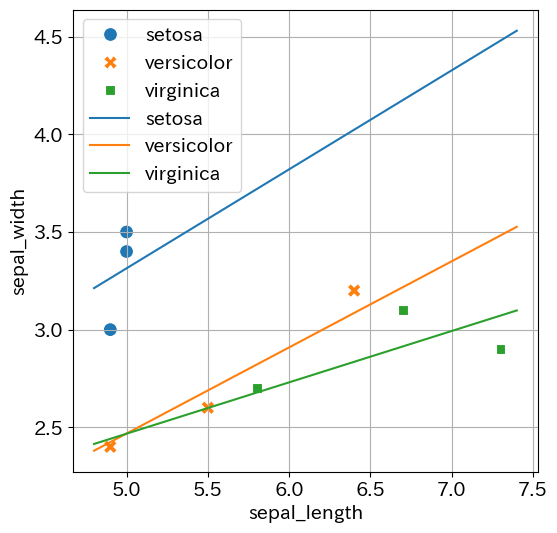

In [13]:
# alphaとbetaの平均値の導出
means = summary1['mean']
alpha0 = means['sepal_length|species[setosa]']
alpha1 = means['sepal_length|species[versicolor]']
alpha2 = means['sepal_length|species[virginica]']
beta0 = means['1|species[setosa]']
beta1 = means['1|species[versicolor]']
beta2 = means['1|species[virginica]']

# 回帰直線用座標値の計算
x_range = np.array([X.min()-0.1,X.max()+0.1])
y0_range = alpha0 * x_range + beta0
y1_range = alpha1 * x_range + beta1
y2_range = alpha2 * x_range + beta2

# 散布図表示
sns.scatterplot(
    x='sepal_length', y='sepal_width', hue='species', style='species',
    data=df_sel, s=100)
plt.plot(x_range, y0_range, label='setosa')
plt.plot(x_range, y1_range, label='versicolor')
plt.plot(x_range, y2_range, label='virginica')
plt.legend();

#### オリジナルの散布図と回帰直線の重ね描き

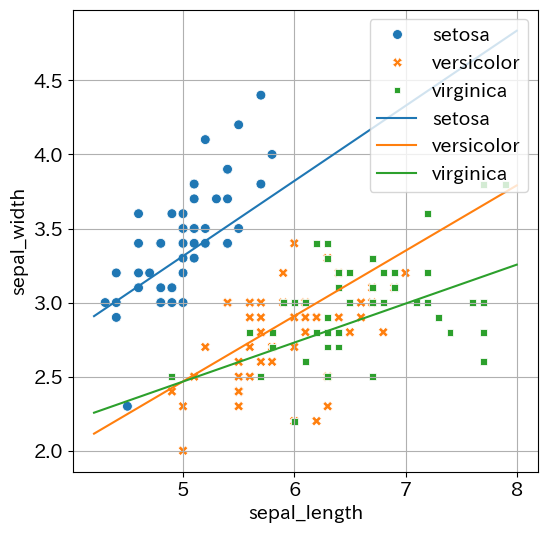

In [14]:
# 回帰直線の座標値計算
x_range = np.array([
    df['sepal_length'].min()-0.1,
    df['sepal_length'].max()+0.1])
y0_range = alpha0 * x_range + beta0
y1_range = alpha1 * x_range + beta1
y2_range = alpha2 * x_range + beta2

# 散布図表示
sns.scatterplot(
    x='sepal_length', y='sepal_width', hue='species', style='species',
    s=50, data=df)
plt.plot(x_range, y0_range, label='setosa')
plt.plot(x_range, y1_range, label='versicolor')
plt.plot(x_range, y2_range, label='virginica')
plt.legend();

#### バージョンの確認

In [15]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

matplotlib         : 3.9.1
japanize_matplotlib: 1.1.3
bambi              : 0.14.0
numpy              : 1.26.4
arviz              : 0.19.0
seaborn            : 0.13.2
pandas             : 2.2.2
pymc               : 5.16.2

